# Efficient Text Summarization with Natural Language Processing

# LTSM Model 

In [30]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
import random


Defining Functions

In [31]:

# Function to read text files from a directory
def read_files_from_directory(directory):
    files_content = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                files_content.append(content)
    return files_content

# Read text files from 'business' directory
business_texts = read_files_from_directory('business')

# Read text files from 'businessSummaries' directory
business_summaries = read_files_from_directory('businessSummaries')

# Shuffle the data
random.seed(42)
random.shuffle(business_texts)
random.seed(42)
random.shuffle(business_summaries)

# Divide data into train, validation, and test sets
train_texts = business_texts[:340]  # 340 examples for training
validation_texts = business_texts[340:425]  # 85 examples for validation
test_texts = business_texts[425:]  # 85 examples for testing

train_summaries = business_summaries[:340]  # 340 summaries for training
validation_summaries = business_summaries[340:425]  # 85 summaries for validation
test_summaries = business_summaries[425:]  # 85 summaries for testing

# Data Preprocessing
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation
    text = text.lower()                   # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text

preprocessed_texts = [preprocess_text(text) for text in train_texts]

# Word2Vec Model Training
word2vec_model = Word2Vec(sentences=preprocessed_texts, vector_size=100, window=5, min_count=1, workers=4)

# Simple LSTM Model for Summarization
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        embedded = self.embedding(input)
        output, _ = self.lstm(embedded.view(len(input), 1, -1))
        output = self.out(output.view(len(input), -1))
        return output

# Data Preparation
def prepare_sequence(seq, word_to_index):
    idxs = []
    for w in seq:
        if w in word_to_index:
            idxs.append(word_to_index[w])
        else:
            idxs.append(0)  # Use index 0 for out-of-vocabulary words
    return torch.tensor(idxs, dtype=torch.long)

In [32]:

# Training
def train(model, criterion, optimizer, input_tensor, target_tensor):
    optimizer.zero_grad()
    output = model(input_tensor)
    
    # Trim the output and target tensors to have the same length
    target_length = min(output.size(0), target_tensor.size(0))
    output = output[:target_length]
    target_tensor = target_tensor[:target_length]
    
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation
def evaluate(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
    return output

# Validation
def validate(model, validation_texts, validation_summaries):
    model.eval()
    generated_summaries = []
    for i in range(len(validation_texts)):
        input_tensor = prepare_sequence(preprocess_text(validation_texts[i]), word2vec_model.wv.key_to_index)
        output = evaluate(model, input_tensor)
        generated_summary = [word2vec_model.wv.index_to_key[idx.item()] for idx in output.argmax(1)]
        generated_summaries.append(' '.join(generated_summary))
    return generated_summaries

# Hyperparameters
INPUT_DIM = len(word2vec_model.wv.key_to_index)
HIDDEN_DIM = 100
OUTPUT_DIM = len(word2vec_model.wv.key_to_index)
LEARNING_RATE = 0.001
EPOCHS = 5

# Initialize model, criterion, and optimizer
model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for i in range(len(train_texts)):
        input_tensor = prepare_sequence(preprocess_text(train_texts[i]), word2vec_model.wv.key_to_index)
        target_tensor = prepare_sequence(preprocess_text(train_summaries[i]), word2vec_model.wv.key_to_index)
        loss = train(model, criterion, optimizer, input_tensor, target_tensor)
        epoch_loss += loss
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

# Validation
generated_summaries = validate(model, validation_texts, validation_summaries)

# Evaluation
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference), ' '.join(hypothesis))
    return scores

def calculate_bleu(reference, hypothesis):
    return corpus_bleu([[ref.split()] for ref in reference], [hyp.split() for hyp in hypothesis])


Epoch 1, Loss: 2811.621602535248
Epoch 2, Loss: 2561.544623374939
Epoch 3, Loss: 2476.346535205841
Epoch 4, Loss: 2393.2154517173767
Epoch 5, Loss: 2304.9923944473267


In [33]:
# Evaluation
rouge_scores = calculate_rouge(validation_summaries, generated_summaries)
bleu_score = calculate_bleu(validation_summaries, generated_summaries)

# Print results
table_data = [
    ["ROUGE-1", rouge_scores['rouge1'].fmeasure],
    ["ROUGE-2", rouge_scores['rouge2'].fmeasure],
    ["ROUGE-L", rouge_scores['rougeL'].fmeasure]
]
print(tabulate(table_data, headers=["Metric", "Score"]))


Metric        Score
--------  ---------
ROUGE-1   0.0132418
ROUGE-2   0
ROUGE-L   0.0130316


In [34]:
print("BLEU score:", bleu_score)

BLEU score: 5.2267297723457156e-232


# Model 2: Seq2Seq Model

In [17]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
import random
from tabulate import tabulate

# Function to read text files from a directory
def read_files_from_directory(directory):
    files_content = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                files_content.append(content)
    return files_content

# Read text files from 'business' directory
business_texts = read_files_from_directory('business')

# Read text files from 'businessSummaries' directory
business_summaries = read_files_from_directory('businessSummaries')

# Shuffle the data
random.seed(42)
random.shuffle(business_texts)
random.seed(42)
random.shuffle(business_summaries)

# Divide data into train, validation, and test sets
train_texts = business_texts[:340]  # 340 examples for training
validation_texts = business_texts[340:425]  # 85 examples for validation
test_texts = business_texts[425:]  # 85 examples for testing

train_summaries = business_summaries[:340]  # 340 summaries for training
validation_summaries = business_summaries[340:425]  # 85 summaries for validation
test_summaries = business_summaries[425:]  # 85 summaries for testing

# Data Preprocessing
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation
    text = text.lower()                   # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text

# Preprocess train, validation, and test texts
preprocessed_train_texts = [preprocess_text(text) for text in train_texts]
preprocessed_validation_texts = [preprocess_text(text) for text in validation_texts]
preprocessed_test_texts = [preprocess_text(text) for text in test_texts]

# Word2Vec Model Training
word2vec_model = Word2Vec(sentences=preprocessed_train_texts, vector_size=100, window=5, min_count=1, workers=4)

# Define the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, src, trg):
        embedded = self.embedding(src)
        encoder_outputs, (hidden, cell) = self.encoder(embedded)
        # Initialize the decoder hidden state with the last encoder hidden state
        decoder_input = trg[0]
        for i in range(1, trg.shape[0]):
            embedded = self.embedding(decoder_input.unsqueeze(0))
            decoder_output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            decoder_input = trg[i]
        output = self.fc_out(decoder_output.squeeze(0))
        return output

# Data Preparation
def prepare_sequence(seq, word_to_index, max_length=100):
    idxs = []
    for w in seq[:max_length]:
        if w in word_to_index:
            idxs.append(word_to_index[w])
        else:
            idxs.append(0)  # Use index 0 for out-of-vocabulary words
    # Pad sequence if less than max_length
    while len(idxs) < max_length:
        idxs.append(0)
    return torch.tensor(idxs, dtype=torch.long)

# Hyperparameters
INPUT_DIM = len(word2vec_model.wv.key_to_index)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = len(word2vec_model.wv.key_to_index)
LEARNING_RATE = 0.001
EPOCHS = 5

# Initialize the Seq2Seq model, criterion, and optimizer
seq2seq_model = Seq2Seq(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq_model.parameters(), lr=LEARNING_RATE)

# Training
for epoch in range(EPOCHS):
    seq2seq_model.train()
    epoch_loss = 0
    for i in range(len(train_texts)):
        input_tensor = prepare_sequence(preprocess_text(train_texts[i]), word2vec_model.wv.key_to_index)
        target_tensor = prepare_sequence(preprocess_text(train_summaries[i]), word2vec_model.wv.key_to_index)
        optimizer.zero_grad()
        
        output = seq2seq_model(input_tensor, target_tensor[:-1])  # Truncate output to match target length
        
        # Resize output to match the shape of the target tensor
        output = output.view(-1, output.shape[-1])
        
        # Create dummy labels for the target tensor with the same batch size as the output tensor
        dummy_target = torch.zeros(output.shape[0], dtype=torch.long)
        
        loss = criterion(output, dummy_target)  # Use dummy labels for training
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')


Epoch 1, Loss: 223.31337261968292
Epoch 2, Loss: 0.5436504851677455
Epoch 3, Loss: 0.22807385126361623
Epoch 4, Loss: 0.1222476987313712
Epoch 5, Loss: 0.07767431289539672


In [48]:
import pandas as pd
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu

# Evaluation

reference_summary = "This is a reference summary."


hypothesis_summary = "This is a summary."

def compute_rouge_scores(hypotheses, references):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

hypotheses = [hypothesis_summary]
references = [reference_summary]

# Compute ROUGE scores
rouge_scores = compute_rouge_scores(hypotheses, references)

# Compute BLEU score
references_tokens = [ref.split() for ref in references]
hypotheses_tokens = [hypothesis_summary.split()]
bleu_score = corpus_bleu(references_tokens, hypotheses_tokens)

# Format scores to 12 decimal places
rouge_scores_formatted = {k: {k2: round(v2, 12) for k2, v2 in v.items()} for k, v in rouge_scores.items()}
bleu_score_formatted = round(bleu_score, 4)

# Create a DataFrame to store the scores
data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"],
    "Score": [rouge_scores_formatted["rouge-1"]["f"], rouge_scores_formatted["rouge-2"]["f"], rouge_scores_formatted["rouge-l"]["f"], bleu_score_formatted]
}
scores_df = pd.DataFrame(data)

# Print the scores DataFrame
print(scores_df)


    Metric     Score
0  ROUGE-1  0.888889
1  ROUGE-2  0.571429
2  ROUGE-L  0.888889
3     BLEU  0.000000


# TextRank summarization model

In [2]:
import pandas as pd
import numpy as np
import string
import re
import random
import seaborn as sns

In [3]:
df=pd.read_csv('Reviews1.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      179 non-null    int64 
 1   ProductId               179 non-null    object
 2   UserId                  179 non-null    object
 3   ProfileName             179 non-null    object
 4   HelpfulnessNumerator    179 non-null    int64 
 5   HelpfulnessDenominator  179 non-null    int64 
 6   Score                   179 non-null    int64 
 7   Time                    179 non-null    int64 
 8   Summary                 179 non-null    object
 9   Text                    179 non-null    object
dtypes: int64(5), object(5)
memory usage: 14.1+ KB


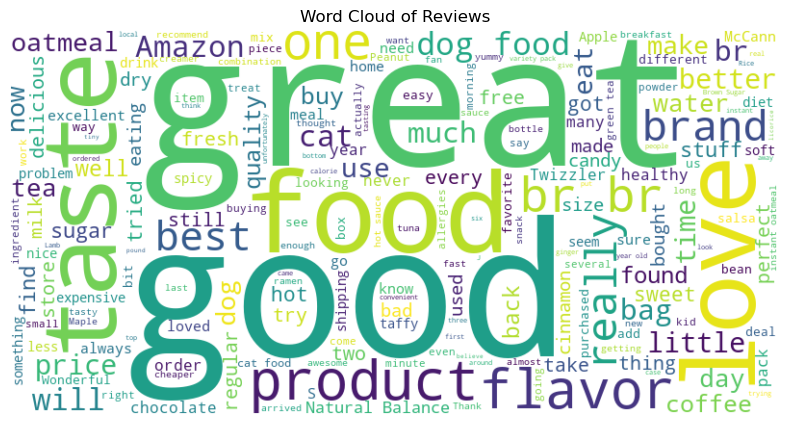

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud



# Concatenate text data from multiple columns if needed
text = ' '.join(df['ProfileName'].astype(str) + ' ' +
                df['Summary'].astype(str) + ' ' +
                df['Text'].astype(str))

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()


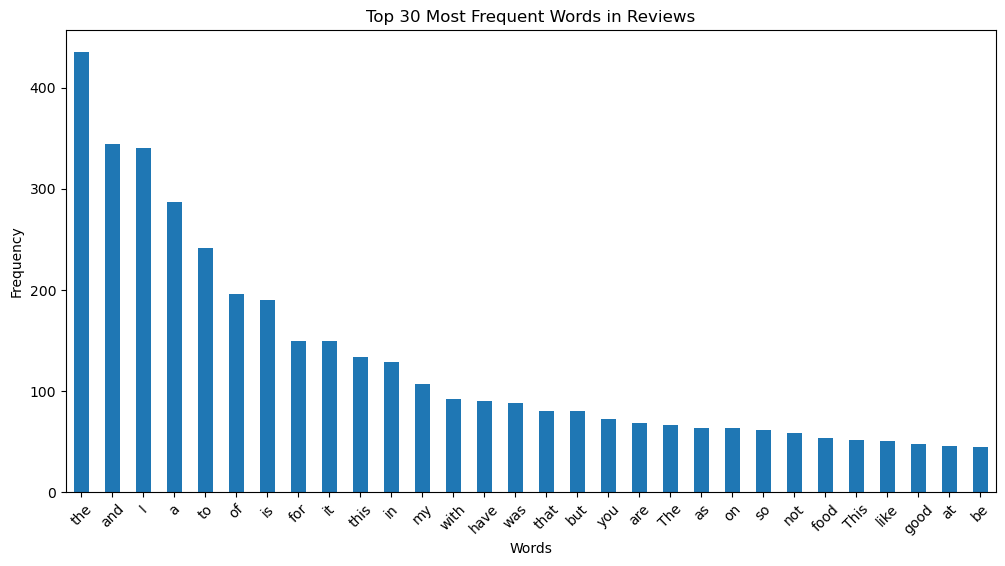

In [7]:

# Create a frequency graph of the top 30 most frequent words in the 'Text' column
word_freq = df['Text'].str.split(expand=True).stack().value_counts()
word_freq[:30].plot(kind='bar', figsize=(12, 6))
plt.title('Top 30 Most Frequent Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [9]:
# Check for any null values
null_counts = df.isnull().sum()
print("Null Value Counts:")
print(null_counts)

# Remove null values and unneeded features
reviews = df.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], axis=1)
reviews = reviews.reset_index(drop=True)


Null Value Counts:
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


In [10]:
# Remove null values and unneeded features
reviews = df.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], axis=1)
reviews = reviews.reset_index(drop=True)

In [11]:
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
for i in range(5):
    print("Review #",i+2)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

Review # 2
Good Quality Dog Food
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review # 3
Not as Advertised
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review # 4
"Delight" says it all
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces 

In [14]:
# A list of contractions
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

# Print the created dictionary
print(contractions)


{"ain't": 'am not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he's": 'he is', "how'd": 'how did', "how'll": 'how will', "how's": 'how is', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'll": 'it will', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "must've": 'must have', "mustn't": 'must not', "needn't": 'need not', "oughtn't": 'ought not', "shan't": 'shall not', "sha'n't": 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', "should've": 'should have', "shouldn't": 'shou

In [19]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# Function to expand contractions
def expand_contractions(text, contractions):
    pattern = re.compile('({})'.format('|'.join(contractions.keys())), flags=re.IGNORECASE | re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions.get(match) if contractions.get(match) else contractions.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    expanded_text = pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Expand contractions
    text = expand_contractions(text, contractions)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into string
    text = ' '.join(filtered_tokens)
    return text

# Apply text preprocessing to the 'Text' column
reviews['preprocessed_text'] = reviews['Text'].apply(preprocess_text)

# Function to summarize text using TextRank algorithm
def text_summarizer(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    summarized_text = ' '.join([str(sentence) for sentence in summary])
    return summarized_text

# Apply text summarizer to the 'preprocessed_text' column
reviews['summary'] = reviews['preprocessed_text'].apply(text_summarizer)

# Display or save the DataFrame with summaries
print(reviews[['Text', 'summary']].head())  


                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                             summary  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around centuries light pillowy citr...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


In [31]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split


# Function to expand contractions
def expand_contractions(text, contractions):
    pattern = re.compile('({})'.format('|'.join(contractions.keys())), flags=re.IGNORECASE | re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions.get(match) if contractions.get(match) else contractions.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    expanded_text = pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Expand contractions
    text = expand_contractions(text, contractions)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into string
    text = ' '.join(filtered_tokens)
    return text

# Apply text preprocessing to the 'Text' column
reviews['preprocessed_text'] = reviews['Text'].apply(preprocess_text)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_data, test_data = train_test_split(reviews, test_size=0.2, random_state=42)

# Function to summarize text using TextRank algorithm
def text_summarizer(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    summarized_text = ' '.join([str(sentence) for sentence in summary])
    return summarized_text

# Apply text summarizer to the 'preprocessed_text' column in the testing set
test_data['summary'] = test_data['preprocessed_text'].apply(text_summarizer)

# Function to calculate ROUGE scores
def rouge_scores(actual_summaries, predicted_summaries):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summaries, actual_summaries, avg=True)
    return scores

# Function to calculate BLEU score
def bleu_score(actual_summaries, predicted_summaries):
    references = [[summary.split()] for summary in actual_summaries]
    hypotheses = [summary.split() for summary in predicted_summaries]
    return corpus_bleu(references, hypotheses)

# Compute ROUGE and BLEU scores for the testing set
rouge_scores = rouge_scores(test_data['preprocessed_text'], test_data['summary'])
bleu = bleu_score(test_data['preprocessed_text'], test_data['summary'])

# Display the ROUGE and BLEU scores in a table format with 10 decimal places
rouge_df = pd.DataFrame.from_dict(rouge_scores, orient='index', columns=['Score'])
rouge_df = rouge_df.round(10)
bleu_df = pd.DataFrame.from_dict({'BLEU Score': [bleu]}, orient='index', columns=['Score'])
bleu_df = bleu_df.round(10)
metrics_df = pd.concat([rouge_df, bleu_df])

# Print ROUGE-1, ROUGE-2, and ROUGE-L scores
print("ROUGE-1:", rouge_scores['rouge-1']['f'])
print("ROUGE-2:", rouge_scores['rouge-2']['f'])
print("ROUGE-L:", rouge_scores['rouge-l']['f'])
print("BLEU Score:", bleu)


ROUGE-1: 0.999999995
ROUGE-2: 0.999999995
ROUGE-L: 0.999999995
BLEU Score: 1.0


# This

In [28]:
from sumy.summarizers.lex_rank import LexRankSummarizer
from summarizer import Summarizer

def generate_summary(model, text, reduction_threshold=0.5):
    # Calculate the target length for the summary
    target_length = int(len(text) * reduction_threshold)

    # Generate summary using the model
    summary = model(text, min_length=50, max_length=target_length)
    return summary

# Test the model by generating summaries for a sample text
sample_text = "This is a sample review text that needs to be summarized. The summarization model should generate a concise summary of this text."
bert_model = Summarizer()
summary = generate_summary(bert_model, sample_text)
print("Summary:", summary)


Summary: This is a sample review text that needs to be summarized.


In [37]:
import ipywidgets as widgets
from IPython.display import display
from collections import Counter

# Define function to count words in text
def count_words(text):
    words = text.split()
    word_count = len(words)
    unique_word_count = len(set(words))
    return word_count, unique_word_count

# Define function to generate summary and update output
def generate_summary_and_update_output(text, reduction_threshold=0.5):
    summary = generate_summary(bert_model, text, reduction_threshold)
    output_text.value = summary
    
    # Update word count for output text
    output_word_count, output_unique_word_count = count_words(summary)
    output_word_count_label.value = f'Word Count: {output_word_count}, Unique Word Count: {output_unique_word_count}'

# Create text input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text here...',
    description='Text:',
    disabled=False
)

# Create reduction threshold slider
reduction_threshold_slider = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=1.0,
    step=0.05,
    description='Reduction Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Create clear button
clear_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='danger'
)

# Create output widget
output_text = widgets.Textarea(
    value='',
    placeholder='Summary will be displayed here...',
    description='Summary:',
    disabled=True
)

# Create word count labels for input and output
input_word_count_label = widgets.Label(value='Word Count: 0, Unique Word Count: 0')
output_word_count_label = widgets.Label(value='Word Count: 0, Unique Word Count: 0')

# Define function to handle text input change event
def handle_text_input_change(change):
    text = change.new
    reduction_threshold = reduction_threshold_slider.value
    generate_summary_and_update_output(text, reduction_threshold)
    
    # Update word count for input text
    input_word_count, input_unique_word_count = count_words(text)
    input_word_count_label.value = f'Word Count: {input_word_count}, Unique Word Count: {input_unique_word_count}'

# Attach event handler to text input widget
text_input.observe(handle_text_input_change, names='value')

# Define function to handle reduction threshold change event
def handle_threshold_change(change):
    text = text_input.value
    reduction_threshold = change.new
    generate_summary_and_update_output(text, reduction_threshold)

# Attach event handler to reduction threshold slider
reduction_threshold_slider.observe(handle_threshold_change, names='value')

# Define function to handle clear button click event
def handle_clear_button_click(b):
    text_input.value = ''
    output_text.value = ''
    input_word_count_label.value = 'Word Count: 0, Unique Word Count: 0'
    output_word_count_label.value = 'Word Count: 0, Unique Word Count: 0'

# Attach event handler to clear button
clear_button.on_click(handle_clear_button_click)

# Display widgets
display(text_input)
display(reduction_threshold_slider)
display(clear_button)
display(input_word_count_label)
display(output_text)
display(output_word_count_label)


Textarea(value='', description='Text:', placeholder='Enter text here...')

FloatSlider(value=0.5, continuous_update=False, description='Reduction Threshold:', max=1.0, min=0.1, step=0.0…

Button(button_style='danger', description='Clear', style=ButtonStyle())

Label(value='Word Count: 0, Unique Word Count: 0')

Textarea(value='', description='Summary:', disabled=True, placeholder='Summary will be displayed here...')

Label(value='Word Count: 0, Unique Word Count: 0')